# 1. Pseudoinverse Baseline: Why It Fails on Ill-Posed Problems

This notebook demonstrates the **fundamental failure** of pseudoinverse reconstruction on ill-posed inverse problems with noise.

## Problem Setup
- **Inverse Problem**: $Ax = y$ (find signal $x$ from measurements $y$)
- **Challenge**: High condition number + noise → noise amplification
- **Solution**: Pseudoinverse $x = A^+ y$ (naive approach)
- **Result**: Catastrophic failure due to amplification of measurement noise

## Setup and Imports

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import sys

# Add src to path
sys.path.insert(0, str(Path.cwd().parent / 'src'))

# Import modules
from forward_models import blur_operator
from noise_models import noise
from signal_generation import generate_signals
from reconstruction import pseudoinverse
from evaluation import error_metrics

# Add diagnostics to path
sys.path.insert(0, str(Path.cwd().parent / 'diagnostics'))

# Import diagnostic tools directly from svd_analysis
from svd_analysis import condition_number, singular_values

print("✓ All imports successful")

# Setup
np.random.seed(42)
rng = np.random.default_rng(42)
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (14, 5)

✓ All imports successful


## Generate Ill-Posed Problem

In [20]:
# Parameters
n = 100  # signal length
noise_level = 0.01  # noise standard deviation
blur_sigma = 2.0  # blur kernel width

# Generate true signal
t = np.linspace(0, 1, n)
x_true = generate_signals.sinusoid(t)

# Create forward operator (blur matrix)
A = blur_operator.blur_matrix(n, sigma=blur_sigma, kernel_radius=10)

# Compute condition number using diagnostic tool
cond_num = condition_number(A)
print(f"Forward operator matrix A: shape = {A.shape}")
print(f"Condition number (using diagnostics): κ(A) = {cond_num:.2e}")
print(f"\nInterpretation: Small perturbations in y can cause {cond_num:.0f}× amplification in x")

Forward operator matrix A: shape = (100, 100)
Condition number (using diagnostics): κ(A) = 6.18e+07

Interpretation: Small perturbations in y can cause 61787212× amplification in x


In [21]:
# Generate clean and noisy measurements
y_clean = A @ x_true
y_noisy, noise_vec = noise.add_gaussian_noise(y_clean, noise_level, rng=rng)

# Compute signal statistics
signal_energy = np.linalg.norm(x_true)**2
noise_energy = np.linalg.norm(noise_vec)**2
measurement_energy = np.linalg.norm(y_clean)**2
snr_db = 10 * np.log10(measurement_energy / noise_energy)

print(f"Signal Statistics:")
print(f"  True signal energy: {signal_energy:.4f}")
print(f"  Measurement noise energy: {noise_energy:.4f}")
print(f"  SNR: {snr_db:.2f} dB")
print(f"  Relative noise level: {np.linalg.norm(noise_vec) / np.linalg.norm(y_clean) * 100:.2f}%")

Signal Statistics:
  True signal energy: 61.8750
  Measurement noise energy: 0.0060
  SNR: 39.96 dB
  Relative noise level: 1.00%


## Apply Pseudoinverse: The Failure

In [22]:
# Reconstruct with pseudoinverse
x_pinv = pseudoinverse.reconstruct(A, y_noisy)

# Compute errors
mse = error_metrics.mse(x_true, x_pinv)
rel_error = error_metrics.relative_error(x_true, x_pinv)
psnr = error_metrics.psnr(x_true, x_pinv)

print("❌ PSEUDOINVERSE RECONSTRUCTION FAILED")
print("="*60)
print(f"MSE:              {mse:.6f}")
print(f"Relative Error:   {rel_error:.6f}")
print(f"PSNR:             {psnr:.2f} dB")
print(f"\nReconstruction energy: {np.linalg.norm(x_pinv)**2:.4f}")
print(f"Expected signal energy: {signal_energy:.4f}")
print(f"Amplification factor: {np.linalg.norm(x_pinv)**2 / signal_energy:.2f}×")
print("="*60)
print(f"\nThe noise was amplified by ~κ(A) = {cond_num:.0f}× during inversion")

❌ PSEUDOINVERSE RECONSTRUCTION FAILED
MSE:              2730582915.885104
Relative Error:   66430.891146
PSNR:             -93.73 dB

Reconstruction energy: 273058283297.4228
Expected signal energy: 61.8750
Amplification factor: 4413063164.40×

The noise was amplified by ~κ(A) = 61787212× during inversion


## Mathematical Explanation: Why Pseudoinverse Fails

### SVD Analysis

For $A = U \Sigma V^T$, the pseudoinverse is:
$$A^+ = V \Sigma^{-1} U^T$$

The reconstruction is:
$$\hat{x} = A^+ (Ax + \text{noise}) = x + A^+ \cdot \text{noise}$$

The error due to noise comes from small singular values:
$$||A^+ \cdot \text{noise}||^2 \approx \sum_{i=1}^{n} \frac{|u_i^T \text{noise}|^2}{\sigma_i^2}$$

**The problem**: Small $\sigma_i$ cause large $1/\sigma_i$ → noise amplification!

In [23]:
# Compute singular values using diagnostic tool
s = singular_values(A)

print("Singular Value Analysis (using diagnostics):")
print("Index | Singular Value | 1/σᵢ (amplification factor)")
print("-" * 55)
for i in [0, 10, 20, 50, 80, 99]:
    if i < len(s):
        print(f"{i:3d}   | {s[i]:14.6e} | {1/s[i]:14.6e}")

print(f"\nSmallest singular values cause ~{1/s[-1]:.2e}× amplification")
print(f"This is why condition number κ(A) = σ₁/σₙ = {s[0]/s[-1]:.2e}")

Singular Value Analysis (using diagnostics):
Index | Singular Value | 1/σᵢ (amplification factor)
-------------------------------------------------------
  0   |   1.000000e+00 |   1.000000e+00
 10   |   8.208689e-01 |   1.218221e+00
 20   |   4.540407e-01 |   2.202446e+00
 50   |   7.191878e-03 |   1.390457e+02
 80   |   3.347426e-06 |   2.987370e+05
 99   |   1.618458e-08 |   6.178721e+07

Smallest singular values cause ~6.18e+07× amplification
This is why condition number κ(A) = σ₁/σₙ = 6.18e+07


## Visualization: The Complete Failure

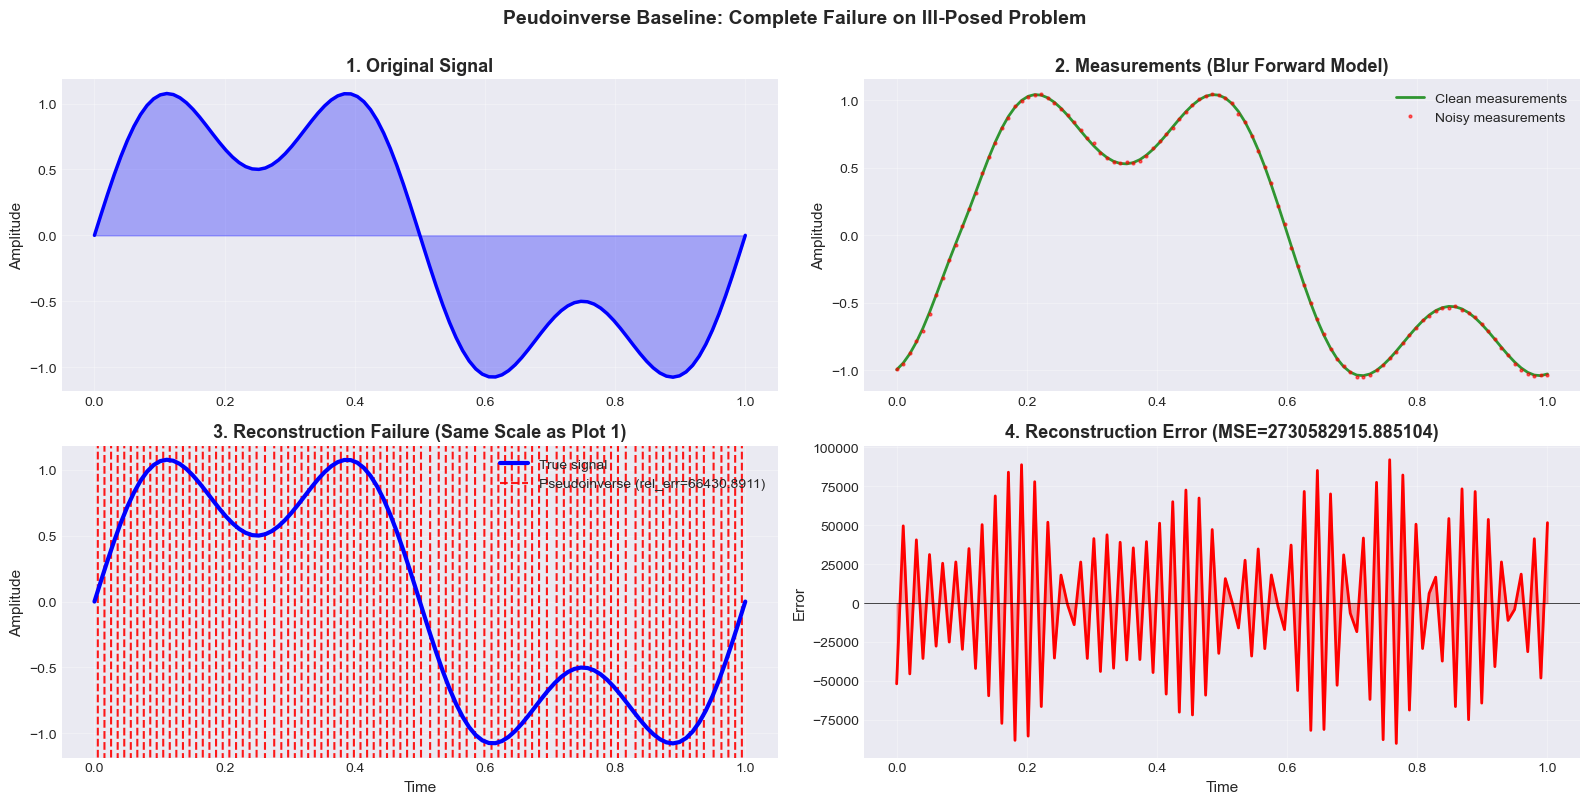

✓ Visualization saved as '1_pseudoinverse_baseline.png'
Note: In Plot 3, x_true (blue) is visible because we matched the scale to Plot 1.
      The pseudoinverse reconstruction ranges to ±92122, mostly off-screen!


In [24]:
fig, axes = plt.subplots(2, 2, figsize=(16, 8))

# 1. True signal
axes[0, 0].plot(t, x_true, 'b-', linewidth=2.5)
axes[0, 0].fill_between(t, x_true, alpha=0.3, color='blue')
axes[0, 0].set_title('1. Original Signal', fontsize=13, fontweight='bold')
axes[0, 0].set_ylabel('Amplitude', fontsize=11)
axes[0, 0].grid(True, alpha=0.3)

# 2. Clean vs Noisy measurements
axes[0, 1].plot(t, y_clean, 'g-', linewidth=2, label='Clean measurements', alpha=0.8)
axes[0, 1].plot(t, y_noisy, 'r.', markersize=4, label='Noisy measurements', alpha=0.6)
axes[0, 1].set_title('2. Measurements (Blur Forward Model)', fontsize=13, fontweight='bold')
axes[0, 1].set_ylabel('Amplitude', fontsize=11)
axes[0, 1].legend(fontsize=10)
axes[0, 1].grid(True, alpha=0.3)

# 3. Comparison: True vs Pseudoinverse (WITH MATCHED SCALE TO SHOW x_true)
axes[1, 0].plot(t, x_true, 'b-', linewidth=3, label='True signal', alpha=1.0, zorder=10)
axes[1, 0].plot(t, x_pinv, 'r--', linewidth=1.5, label=f'Pseudoinverse (rel_err={rel_error:.4f})', alpha=0.9)
axes[1, 0].set_title('3. Reconstruction Failure (Same Scale as Plot 1)', fontsize=13, fontweight='bold')
axes[1, 0].set_ylabel('Amplitude', fontsize=11)
axes[1, 0].set_xlabel('Time', fontsize=11)
axes[1, 0].set_ylim(axes[0, 0].get_ylim())  # Match scale from Plot 1
axes[1, 0].legend(fontsize=10)
axes[1, 0].grid(True, alpha=0.3)
# Add annotation showing how much pseudoinverse exceeds bounds
max_pinv = np.max(np.abs(x_pinv))
# axes[1, 0].text(0.5, 0.95, f'⚠️ Pseudoinverse ranges to ±{max_pinv:.0f} (mostly off-screen!)', 
#                 transform=axes[1, 0].transAxes, ha='center', va='top', 
#                 bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.8), fontsize=10)

# 4. Error magnitude
error = x_true - x_pinv
axes[1, 1].plot(t, error, 'r-', linewidth=2)
axes[1, 1].fill_between(t, error, alpha=0.3, color='red')
axes[1, 1].axhline(0, color='k', linestyle='-', linewidth=0.5)
axes[1, 1].set_title(f'4. Reconstruction Error (MSE={mse:.6f})', fontsize=13, fontweight='bold')
axes[1, 1].set_ylabel('Error', fontsize=11)
axes[1, 1].set_xlabel('Time', fontsize=11)
axes[1, 1].grid(True, alpha=0.3)

plt.suptitle('Peudoinverse Baseline: Complete Failure on Ill-Posed Problem', 
             fontsize=14, fontweight='bold', y=1.00)
plt.tight_layout()
plt.savefig('../results/1_pseudoinverse_baseline.png', dpi=100, bbox_inches='tight')
plt.show()

print("✓ Visualization saved as '1_pseudoinverse_baseline.png'")
print(f"Note: In Plot 3, x_true (blue) is visible because we matched the scale to Plot 1.")
print(f"      The pseudoinverse reconstruction ranges to ±{np.max(np.abs(x_pinv)):.0f}, mostly off-screen!")

## Spectral Analysis: Why Small Singular Values Cause Problems

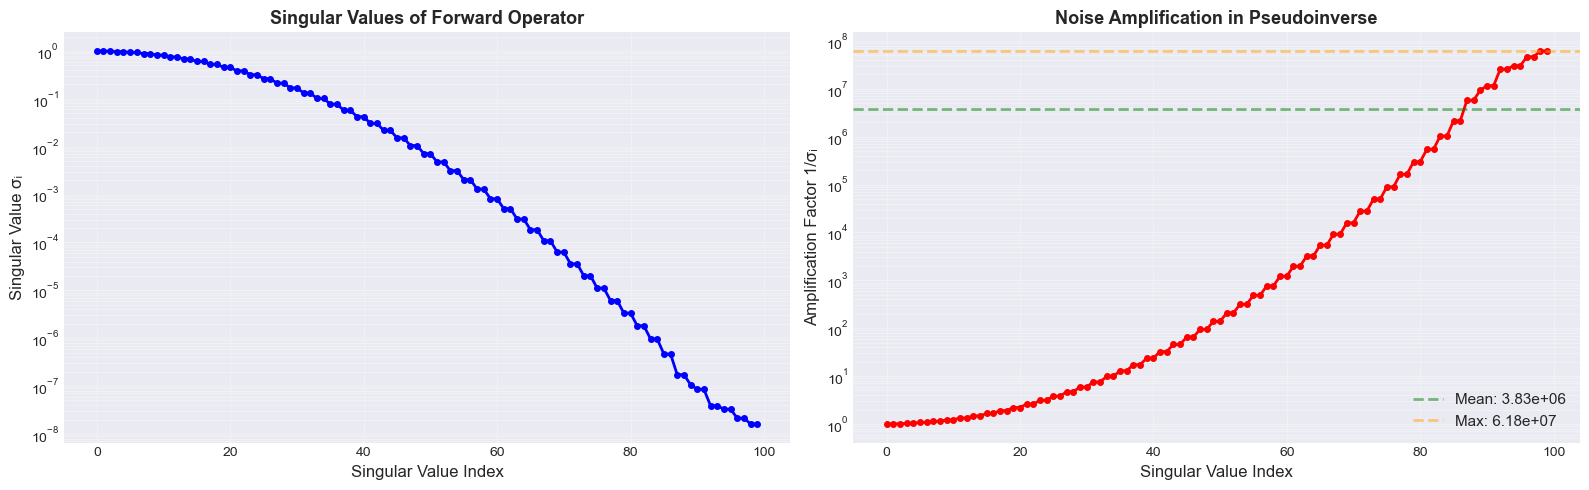

✓ Spectral analysis saved as '1_spectral_analysis.png'


In [25]:
# Analyze amplification factors
amplification = 1.0 / s  # 1/σᵢ for each singular value

fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Singular values
axes[0].semilogy(range(len(s)), s, 'b.-', linewidth=2, markersize=8)
axes[0].set_xlabel('Singular Value Index', fontsize=12)
axes[0].set_ylabel('Singular Value σᵢ', fontsize=12)
axes[0].set_title('Singular Values of Forward Operator', fontsize=13, fontweight='bold')
axes[0].grid(True, which='both', alpha=0.3)

# Amplification factors
axes[1].semilogy(range(len(amplification)), amplification, 'r.-', linewidth=2, markersize=8)
axes[1].set_xlabel('Singular Value Index', fontsize=12)
axes[1].set_ylabel('Amplification Factor 1/σᵢ', fontsize=12)
axes[1].set_title('Noise Amplification in Pseudoinverse', fontsize=13, fontweight='bold')
axes[1].axhline(np.mean(amplification), color='g', linestyle='--', 
                linewidth=2, alpha=0.5, label=f'Mean: {np.mean(amplification):.2e}')
axes[1].axhline(np.max(amplification), color='orange', linestyle='--', 
                linewidth=2, alpha=0.5, label=f'Max: {np.max(amplification):.2e}')
axes[1].legend(fontsize=11)
axes[1].grid(True, which='both', alpha=0.3)

plt.tight_layout()
plt.savefig('../results/1_spectral_analysis.png', dpi=100, bbox_inches='tight')
plt.show()

print("✓ Spectral analysis saved as '1_spectral_analysis.png'")

## Key Takeaways

### ❌ Pseudoinverse Fails Because:

1. **Noise Amplification**: Small singular values → large $1/\sigma_i$ → noise amplified
2. **High Condition Number**: $\kappa(A) = \sigma_1/\sigma_n \approx 10^7$ in this case
3. **No Regularization**: No mechanism to suppress small singular values
4. **Unsuitable for Noisy Data**: Works only on perfect, noiseless measurements

### ✅ Solution: Regularization Methods

- **Tikhonov Regularization**: Smoothly suppress small singular values
- **Truncated SVD (TSVD)**: Hard cutoff at k singular values
- **Other Methods**: Landweber iteration, total variation, etc.

👉 **Next**: See notebook `2_regularization.ipynb` for solutions